# Data Preparation

## Import and Settings

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
import dask
import dask.dataframe as dd
import dask.array as da

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [6]:
df = dd.read_csv('explored_ds.csv')

In [7]:
# allocating columns
category_vars = ['Label', 'Protocol','SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'dst_port_transformed', 'src_port_transformed']
object_vars = ['Dst IP', 'Src IP'] #df.select_dtypes(include=['object']).columns
continuous_vars = df.columns[~df.columns.isin(category_vars) & ~df.columns.isin(object_vars)]

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

---
## PCA

In [9]:
# scale data to reduce influence of large values
x = StandardScaler().fit_transform(df[continuous_vars].values)

### Prining Compoments Composition

The first 50 principle components are calculated to determine a good amount of components in the following.

In [10]:
pca = PCA(n_components='mle')
principalComponents = pca.fit_transform(x)

In [11]:
# rename columns with PC-{#component}
col_names = []
for i in range(principalComponents.shape[1]):
    col_names.append(f'PC-{i}')
principalDf = pd.DataFrame(data = principalComponents, columns = col_names)

In [17]:
df_label = df['Label'].compute()

In [18]:
# add label to PCs
finalDf = pd.concat([principalDf, df_label.reset_index()['Label']], axis = 1)

### Logistic Regression for Test Purposes

Multiple logistic regression models are trained to get insights about the principle components. We choose the amount of components which result in the highest accuracy for the smallest amount of components needed. (Therefore, we incremently select the components with the highest explained variance.)

In [19]:
train, test, train_lbl, test_lbl = train_test_split(finalDf, finalDf[['Label']].reset_index()['Label'], test_size=1/7.0, random_state=0)

In [20]:
scores = []
n = finalDf.shape[1]
for i in range(n):
    logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=10)
    logisticRegr.fit(train[col_names[:i+1]], train_lbl)
    scores.append(logisticRegr.score(test[col_names[:i+1]], test_lbl))
    print('[' + (i+1) * '=' + '>' + (n-i-1) * ' ' + ']' + '\t\t' + f'{i+1}/{n}', end='\r')

AttributeError: 'LogisticRegression' object has no attribute 'explained_variance_'

### Evaluating the Models

In the diagram below, we can see that we reach the highest accuracy at around the first 15 components.

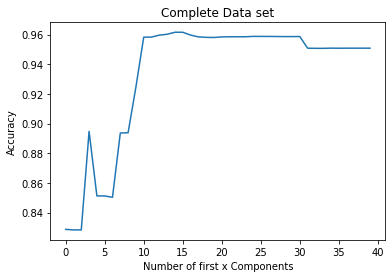

In [66]:
axes = sns.lineplot(data=scores)
axes.set(xlabel = 'Number of first x Components', ylabel = 'Accuracy', title  = 'Complete Data set');

In [69]:
for i in range(len(scores)):
    print(f'{i:3.0f} {scores[i]}')

0 0.8286272105181868
1 0.8282628177916136
2 0.8282628177916136
3 0.8947006754213407
4 0.8511853399441943
5 0.8511807156710144
6 0.8502891558019369
7 0.8936232197704326
8 0.8938479594469739
9 0.9246104743486943
10 0.9582899807722721
11 0.9583500963236103
12 0.9596707887437792
13 0.9602395743449024
14 0.9616139083339577
15 0.9616028100783259
16 0.9597142569116699
17 0.9584805008272824
18 0.9581669751056877
19 0.9580726399328185
20 0.9584721771355588
21 0.9585591134713402
22 0.9585850094011473
23 0.9585674371630639
24 0.9588115987869607
25 0.9588060496591448
26 0.9587764543107937
27 0.9587440843985346
28 0.9586867434111044
29 0.9586858185564684
30 0.9587265121604511
31 0.9508569240629604
32 0.9507598143261833
33 0.9507477912159157
34 0.9508828199927677
35 0.9508310281331531
36 0.9508624731907762
37 0.9508633980454122
38 0.9508624731907762
39 0.9508624731907762


## PCA - df_fast

In [7]:
df_fast = df.sample(frac=0.001, random_state = 1).compute()

In [36]:
x_fast = StandardScaler().fit_transform(df_fast[continuous_vars].values)

*Prining Compoments Composition*

Um eine gute Anzahl von Prinicpal Components zu ermitteln, haben wir uns 50 Stück berechnet und mit jeder neuen Principal Componenet eine logistische Regression berechnet. Die Accuracy wird mit der Anzahl der Komponenten visuell dargestellt. Es lassen sich zwei Knicke feststellen. Der zweite Sprung ist aber zu minimal, dafür dass wir fast 25 neue Komponenten berücksichtigen müssen. Unsere Wahl fällt auf 10 Komponenten.

In [40]:
scores_fast = []
pca_fast = PCA(n_components='mle') #mle
principalComponents_fast = pca_fast.fit_transform(x_fast)

# Create Column Names
col_names = []
for i in range(principalComponents_fast.shape[1]):
    col_names.append(f'PC-{i}')

principalDf_fast = pd.DataFrame(data = principalComponents_fast, columns = col_names)
finalDf_fast = pd.concat([principalDf_fast, df_fast[['Label']].reset_index()['Label']], axis = 1)

train, test, train_lbl, test_lbl = train_test_split(finalDf_fast, finalDf_fast[['Label']].reset_index()['Label'], test_size=1/7.0, random_state=0)

for i in range(finalDf.shape[1]):
    logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=100)
    logisticRegr.fit(train[col_names[:i+1]], train_lbl)
    scores_fast.append(logisticRegr.score(test[col_names[:i+1]], test_lbl))

c:\users\basti\documents\coding\python-venv\data-exploration-project\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\basti\documents\coding\python-venv\data-exploration-project\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

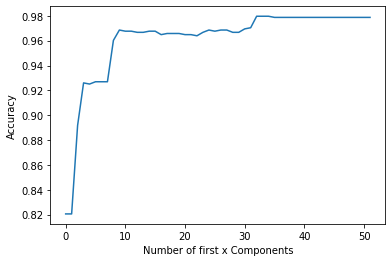

In [42]:
axes = sns.lineplot(data=scores_fast)
axes.set(xlabel = 'Number of first x Components', ylabel = 'Accuracy');

---
## One hot encoding

---
## Cleaning